## Dependencies

In [ ]:
!pip install datasets transformers evaluate transformers[torch] bertviz

In [4]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
from transformers import BertTokenizer, pipeline
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing

In [5]:
# Load the dataset
dataset = load_dataset("dair-ai/emotion")


train_data = dataset['train']
test_data = dataset['test']

train_texts = train_data['text']
train_labels = train_data['label']

test_texts = test_data['text']
test_labels = test_data['label']

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Data Exploration

### Analysis of Word Frequency

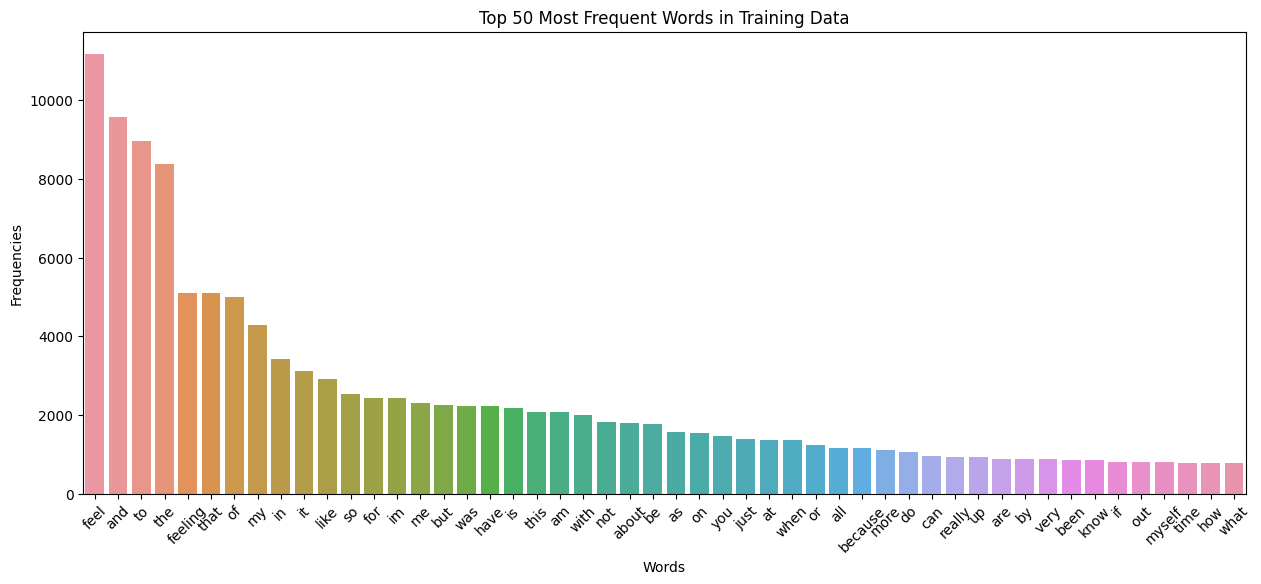

In [ ]:
word_counts = np.asarray(X_train.sum(axis=0)).ravel().tolist()
word_counts_dict = dict(zip(vectorizer.get_feature_names_out(), word_counts))

sorted_word_counts = sorted(word_counts_dict.items(), key=lambda kv: kv[1], reverse=True)

top_n_words = 50
top_words = sorted_word_counts[:top_n_words]
words, counts = zip(*top_words)

plt.figure(figsize=(15, 6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.title(f'Top {top_n_words} Most Frequent Words in Training Data')
plt.show()

### Analysis of Label Distribution

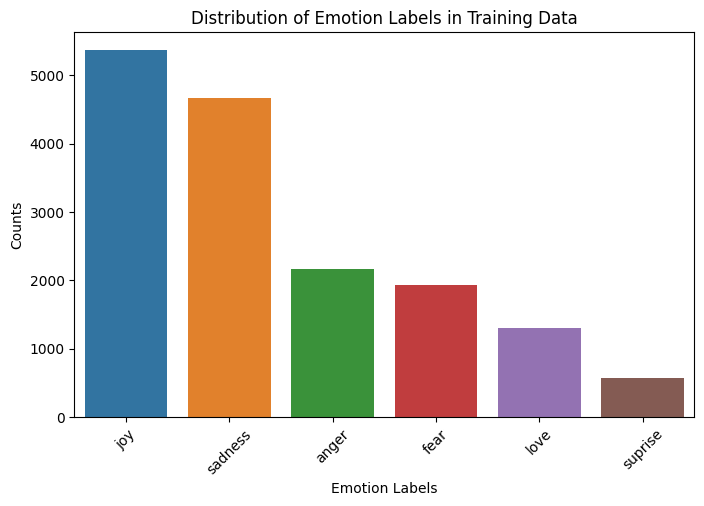

In [ ]:
label_dict = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'suprise'
}

string_train_labels = [label_dict[label] for label in train_labels]

label_counts = pd.Series(string_train_labels).value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=list( label_counts.index), y=list(label_counts.values))
plt.xticks(rotation=45)
plt.xlabel('Emotion Labels')
plt.ylabel('Counts')
plt.title('Distribution of Emotion Labels in Training Data')
plt.show()

### Document Length Analysis

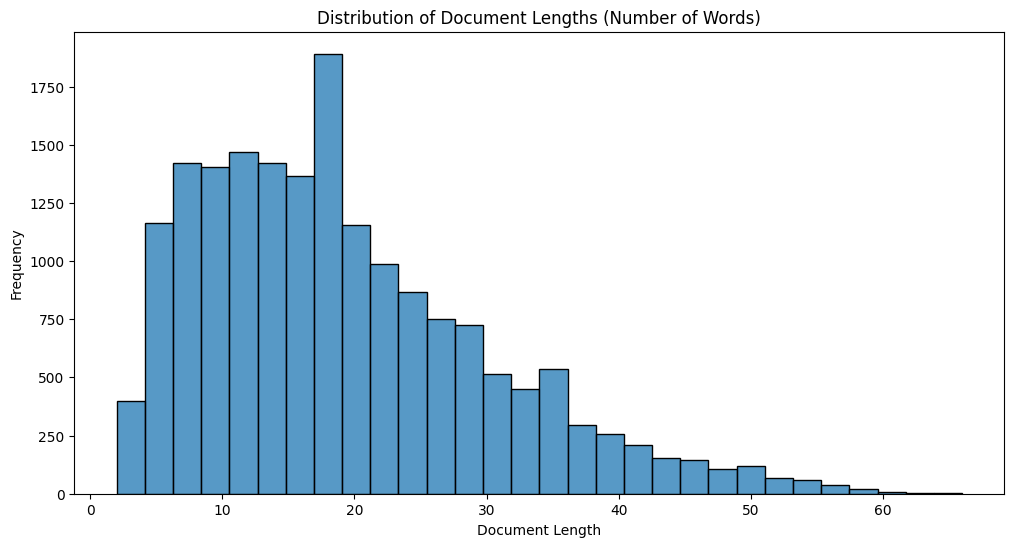

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def count_words(text):
    return len(text.split())

train_lengths = [count_words(doc) for doc in train_texts]
test_lengths = [count_words(doc) for doc in test_texts]

all_lengths = train_lengths + test_lengths

plt.figure(figsize=(12, 6))
sns.histplot(all_lengths, bins=30)
plt.title('Distribution of Document Lengths (Number of Words)')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

## Naive Bayes (Multinomial)

In [6]:
class NaiveBayesModel:

  # Constructor for Naive Bayes => will initialize the model
  def __init__(self):

    # Variable store the log of prior probabilities of each class
    self.log_class_priors = None

    # Variable to store the count of each word in each class
      # Will be a matrix where:
        # each row correspond to a class
        # each column correspond to a word in the vocabulary
    self.word_counts = None

    # Variable will represent the size of the vocabulary -> basically all the unique words
    self.vocab_size = None

    # Variable store the number of unique classes in the dataset
    self.class_count = None


  # Fit method
  # Parameters:
    # X will be all training data features (each row is a new sentence, each column is a specific word in vocab)
    # y will be the corresponding labels
  # Based on parameters, model will fit to
  def fit(self, X, y):

    # Step 1: retrieve and initialize basic training data dimensions
    number_of_sentences, number_of_unique_words = X.shape
    self.vocab_size = number_of_unique_words

    # Step 2: retrieve the number of unique labels from training label using numpy function
    number_of_unique_classes = len(np.unique(y))
    self.class_count = number_of_unique_classes

    # Step 3: form our prior probability about the dataset for each output class
      # Ministep 1 => Using numpy to form a count array that records how many times each class appeared in training data
    count_array_for_classes = np.bincount(y)
      # Ministep 2 => Divide each by total number of sentences(each is a datapoint) to get prior probability,
                    # then convert to log for easy manipulation in the future (log class prior)
    self.log_class_priors = np.log(count_array_for_classes / number_of_sentences)


    # Step 4: Get the word counts per class!
      # Ministep 1 => Initialize word count matrix
        # each row corresponds to a class,
        # each column corresponds THE COUNT of a unique word in vocabulary
        # This structure allows you to keep a count of how often each word appears in documents of each class.
    self.word_counts = np.zeros((self.class_count, self.vocab_size))
      # Ministep 2 =>

        # First, iterate over all output classes
    for curr_class in range(self.class_count):
        # Second, initialize an empty list that will record all input texts that have corresponding output class (same as 'curr_class')
      X_curr_class_list = []
        # Third, add inputs that have the corresponding output class
      for curr_text, curr_label in zip(X, y):
        if curr_label == curr_class:
          X_curr_class_list.append(curr_text)
      X_curr_class = np.array(X_curr_class_list) # Convert back into numpy!


        # Fourthly, initialize a zero array for word counts
      word_counts_for_curr_class = np.zeros(number_of_unique_words)
        # Fifthly, loop through the numpy created just above (which contain all good training data)
      for input_texts in X_curr_class:
        # Sixthly, add word counts
        word_counts_for_curr_class += input_texts

        # Lastly, update word count matrix for the current class!
        self.word_counts[curr_class, :] = word_counts_for_curr_class


    # Apply Laplace smoothing to handle zero probabilies for unseen words
    self.word_counts += 1


  # Method predicts the log probability
  # Parameter:
    # X will be the input data
  def predict_log_probability(self, X):

    # Step 1: initializes an array to hold the log-probability estimates
      # Each row will correspond to a different input text
      # Each column will correspond to a different class
    log_probabilities = np.empty((X.shape[0], self.class_count))

    # Step 2: compute the log probability for each class given an input data
      # Ministep 1: iterate through each class in the dataset
    for curr_class in range(self.class_count):

      # Ministep 2: Convert raw word counts into likelihoods for every word in vocabulary
      word_probability_c = self.word_counts[curr_class, :] / np.sum(self.word_counts[curr_class, :])

      # Ministep 3: Convert to log likelihood
      log_word_probability_c = np.log(word_probability_c)

      # Ministep 4: Perform matrix multiplication with the log probabilities
        # X is a matrix where each row represents a document, and each column corresponds to a word in the vocabulary.
        # log_word_probability_c is a vector containing the logarithm of the probabilities (likelihoods) of each word for the class c.
        # The resulting vector text_log_probs contains the log probabilities of each document in X being in class c.
      text_log_probs = X @ log_word_probability_c

      # Ministep 5: Add the log class priors and store in array
      log_probabilities[:, curr_class] = text_log_probs + self.log_class_priors[curr_class]

    return log_probabilities


  # Method perform prediction on input data
  # Parameter:
    # X will be the input data
  # Will return the class with the maximal probability
  def predict(self, X):
    return np.argmax(self.predict_log_probability(X), axis=1)


  # Method will use the accuracy evaluation method to evaluate model
  # Parameter:

  def accuracy_test(self, prediction, true_label):
    predictions_count = (prediction == true_label)
    num_correct_predictions = np.sum(predictions_count)

    accuracy = num_correct_predictions / len(true_label)

    return accuracy

In [7]:
naive_bayes_model = NaiveBayesModel()
naive_bayes_model.fit(X_train, y_train)
predictions_training = naive_bayes_model.predict(X_train)
accuracy_training = naive_bayes_model.accuracy_test(y_train, predictions_training)
print(f"Model Accuracy: {accuracy_training * 100:.2f}%")

Model Accuracy: 87.61%


## BERT Base Uncased Emotion

In [ ]:
dataset = load_dataset("dair-ai/emotion")

classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

label_encoder = LabelEncoder()
label_encoder.fit(dataset['train']['label'])
num_labels = len(label_encoder.classes_)

def get_predictions(texts, batch_size=32):
    predictions = []
    for i in range(0, len(texts), batch_size):
        print(i)
        batch_texts = texts[i:i+batch_size]
        batch_preds = classifier(batch_texts)
        batch_labels = [max(pred, key=lambda x: x['score'])['label'] for pred in batch_preds]
        predictions.extend(batch_labels)
    return predictions

train_predictions = get_predictions(dataset['train']['text'])
test_predictions = get_predictions(dataset['test']['text'])

label_dict = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5,
}

train_predictions_num = [label_dict[emotion] for emotion in train_predictions]
test_predictions_num = [label_dict[emotion] for emotion in test_predictions]

train_preds_encoded = label_encoder.transform(train_predictions_num)
test_preds_encoded = label_encoder.transform(test_predictions_num)
train_true_encoded = label_encoder.transform(dataset['train']['label'])
test_true_encoded = label_encoder.transform(dataset['test']['label'])

train_accuracy = accuracy_score(train_true_encoded, train_preds_encoded)
test_accuracy = accuracy_score(test_true_encoded, test_preds_encoded)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6496
6528
6560
6592
66

In [ ]:
label_dict = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5,
}

train_predictions_num = [label_dict[emotion] for emotion in train_predictions]
test_predictions_num = [label_dict[emotion] for emotion in test_predictions]

# Encode the predictions and true labels
train_preds_encoded = label_encoder.transform(train_predictions_num)
test_preds_encoded = label_encoder.transform(test_predictions_num)
train_true_encoded = label_encoder.transform(dataset['train']['label'])
test_true_encoded = label_encoder.transform(dataset['test']['label'])

# Calculate accuracy for train and test sets
train_accuracy = accuracy_score(train_true_encoded, train_preds_encoded)
test_accuracy = accuracy_score(test_true_encoded, test_preds_encoded)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9838125
Test Accuracy: 0.9265


## Distilbert Base Uncased Emotion

In [ ]:
dataset = load_dataset("dair-ai/emotion")

classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

label_encoder = LabelEncoder()
label_encoder.fit(dataset['train']['label'])
num_labels = len(label_encoder.classes_)

def get_predictions(texts, batch_size=32):
    predictions = []
    for i in range(0, len(texts), batch_size):
        print(i)
        batch_texts = texts[i:i+batch_size]
        batch_preds = classifier(batch_texts)
        batch_labels = [max(pred, key=lambda x: x['score'])['label'] for pred in batch_preds]
        predictions.extend(batch_labels)
    return predictions

train_predictions = get_predictions(dataset['train']['text'])
test_predictions = get_predictions(dataset['test']['text'])

label_dict = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5,
}

train_predictions_num = [label_dict[emotion] for emotion in train_predictions]
test_predictions_num = [label_dict[emotion] for emotion in test_predictions]

train_preds_encoded = label_encoder.transform(train_predictions_num)
test_preds_encoded = label_encoder.transform(test_predictions_num)
train_true_encoded = label_encoder.transform(dataset['train']['label'])
test_true_encoded = label_encoder.transform(dataset['test']['label'])

train_accuracy = accuracy_score(train_true_encoded, train_preds_encoded)
test_accuracy = accuracy_score(test_true_encoded, test_preds_encoded)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
train_accuracy = accuracy_score(train_true_encoded, train_preds_encoded)
test_accuracy = accuracy_score(test_true_encoded, test_preds_encoded)

In [ ]:
# Gather the indices of correct and incorrect predictions
correct_indices = np.where(train_true_encoded == train_preds_encoded)[0]
incorrect_indices = np.where(train_true_encoded != train_preds_encoded)[0]

# Now, correct_indices and incorrect_indices contain the indices of correct and incorrect predictions respectively
correct_indices.tolist()
incorrect_indices.tolist()

sentence_correct = []
sentence_incorrect = []

for correct_index in correct_indices:
  sentence_correct.append(dataset['train']['text'][correct_index])

for incorrect_index in incorrect_indices:
  sentence_incorrect.append(dataset['train']['text'][incorrect_index])

In [ ]:
sentence_correct

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [ ]:
# The path where the file will be saved
file_path = 'correct.txt'

# Writing the list to a text file
with open(file_path, 'w') as file:
    for item in sentence_correct:
        file.write("%s\n" % item)

file_path # Returning the file path so it can be accessed by the user.

'correct.txt'

In [ ]:
sentence_incorrect

['i feel very strongly passionate about when some jerk off decides to poke and make fun of us',
 'i too feel as if i am a stranger in a strange land and i am raising my son in a place that is not his father s ancestral home',
 'i feel like i ve been neglecting my beloved mom blog',
 'i tend to stop breathing when i m feeling stressed',
 'i saw the video of cena kissing maria and surprisingly i didnt feel like i hated her',
 'i feel hated loathed',
 'i do feel agitated restless or on edge quite often',
 'i feel strange with it because it started to be sale',
 'im feeling generous ill give you a story as well',
 'i also feel a strange sense of guilt about all the people who arent similarly situated to move to a different neighborhood',
 'i say that i feel like im being tortured by him',
 'i feel agitated and empty and missing something',
 'i think i brag and it feels strange because i still see myself as a little fattie pre teen unworthy of any male attention',
 'i feel tortured by somet

In [ ]:
# The path where the file will be saved
file_path = 'incorrect.txt'

# Writing the list to a text file
with open(file_path, 'w') as file:
    for item in sentence_incorrect:
        file.write("%s\n" % item)

file_path # Returning the file path so it can be accessed by the user.

'incorrect.txt'

## Fine-tuning `bhadresh-savani/distilbert-base-uncased-emotion`

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler

dataset = load_dataset("dair-ai/emotion")

tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.remove_columns(["text"])

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion", num_labels=6)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.997}

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.932}

## Attention Matrix Visualization

In [10]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import head_view, model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = "bhadresh-savani/distilbert-base-uncased-emotion"  # Find popular HuggingFace models here: https://huggingface.co/models
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)

input_text_incorrect = [
    "i feel tortured by something",
    # "i feel weird tonight",
    # "i feel rather agitated by our sliding door that keeps getting stuck",
    # "is eyes its questionable whether shes feeling gracious today"
]

input_text_correct = [
    # "i feel complacent if i were to choose the secure path probably not i think id find adventure in anything",
    # "i do eat rawly goodness i feel radiant",
    # "i had a feeling you werent very fond of her",
    "i feel absolutely defeated socially"
]

def modv(input_text):
  inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
  outputs = model(inputs)  # Run model
  attention = outputs[-1]  # Retrieve attention from model outputs
  tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
  model_view(attention, tokens)  # Display model view

def attn_mtx(input_text):
  inputs = tokenizer.encode(input_text, return_tensors='pt')
  outputs = model(inputs)
  attention = outputs[-1]  # Output includes attention weights when output_attentions=True
  tokens = tokenizer.convert_ids_to_tokens(inputs[0])
  head_view(attention, tokens)

(…)uncased-emotion/resolve/main/config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

(…)otion/resolve/main/tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

(…)e-uncased-emotion/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)ion/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
for text in input_text_incorrect:
  attn_mtx(text)

<IPython.core.display.Javascript object>

In [12]:
for text in input_text_correct:
  attn_mtx(text)

<IPython.core.display.Javascript object>

## Freezing all except last few layers for fine-tuning

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove the 'text' column and rename 'label' to 'labels'
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set format to PyTorch tensors
tokenized_datasets.set_format("torch")

# Shuffle and split the dataset
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
test_dataset = tokenized_datasets["test"].shuffle(seed=42)

# DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("bhadresh-savani/distilbert-base-uncased-emotion", num_labels=6)

# Freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last two layers
for layer in [model.distilbert.transformer.layer[-2], model.distilbert.transformer.layer[-1]]:
    for param in layer.parameters():
        param.requires_grad = True

# Optimizer (only updates the unfrozen layers)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

# Training steps
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Check for GPU availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9909375}

In [ ]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.9275}

## Modifying Structure of Pretrained BERT Model

### Base Model Training

In [ ]:
from transformers import DistilBertModel, DistilBertConfig
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
config = DistilBertConfig.from_pretrained(model_name)
model = DistilBertModel(config)

(…)uncased-emotion/resolve/main/config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load tokenizer and dataset
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
dataset = load_dataset("dair-ai/emotion")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Customize the model configuration
config = DistilBertConfig.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

# Initialize the model with custom configuration
model = DistilBertForSequenceClassification(config)

(…)otion/resolve/main/tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

(…)e-uncased-emotion/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)ion/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss
500,1.421800
1000,0.577500
1500,0.311700
2000,0.284700
2500,0.195000
3000,0.170900


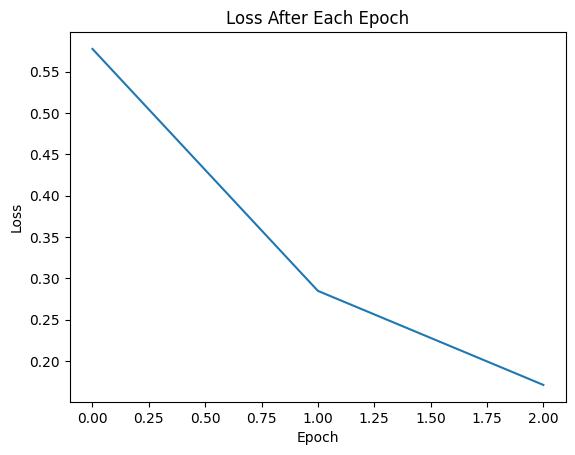

{'eval_loss': 0.2918340861797333, 'eval_accuracy': 0.908, 'eval_runtime': 36.4182, 'eval_samples_per_second': 54.918, 'eval_steps_per_second': 3.432, 'epoch': 3.0}


In [ ]:
from transformers import TrainerCallback, Trainer, TrainingArguments, EvalPrediction
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

class LossPlotCallback(TrainerCallback):
    "A callback that records the loss after each epoch"
    def __init__(self):
        self.losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Record the loss at the end of each epoch
        self.losses.append(state.log_history[-1]['loss'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3
)


# Initialize the callback
loss_plot_callback = LossPlotCallback()

# Initialize Trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[loss_plot_callback]
)

# Train the model
trainer.train()

# Plot the loss
plt.plot(loss_plot_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss After Each Epoch')
plt.show()

validation_results = trainer.evaluate()
print(validation_results)

### ReLU


In [ ]:
from transformers import DistilBertModel, DistilBertConfig
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
config = DistilBertConfig.from_pretrained(model_name)
model = DistilBertModel(config)

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load tokenizer and dataset
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
dataset = load_dataset("dair-ai/emotion")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Customize the model configuration
config = DistilBertConfig.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion', activation="relu")

# Initialize the model with custom configuration
model = DistilBertForSequenceClassification(config)

In [ ]:
from transformers import TrainerCallback, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

class LossPlotCallback(TrainerCallback):
    "A callback that records the loss after each epoch"
    def __init__(self):
        self.losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Record the loss at the end of each epoch
        self.losses.append(state.log_history[-1]['loss'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3
)


# Initialize the callback
loss_plot_callback = LossPlotCallback()

# Initialize Trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[loss_plot_callback]
)

# Train the model
trainer.train()

# Plot the loss
plt.plot(loss_plot_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss After Each Epoch')
plt.show()

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

validation_results = trainer.evaluate()
print(validation_results)

### Dropout rate = 0.2


In [ ]:
from transformers import DistilBertModel, DistilBertConfig
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
config = DistilBertConfig.from_pretrained(model_name)
model = DistilBertModel(config)

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load tokenizer and dataset
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
dataset = load_dataset("dair-ai/emotion")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Customize the model configuration
config = DistilBertConfig.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion', dropout_rate=0.2)


# Initialize the model with custom configuration
model = DistilBertForSequenceClassification(config)

Step,Training Loss
500,1.412700
1000,0.672900
1500,0.366800
2000,0.299400
2500,0.194500
3000,0.180600


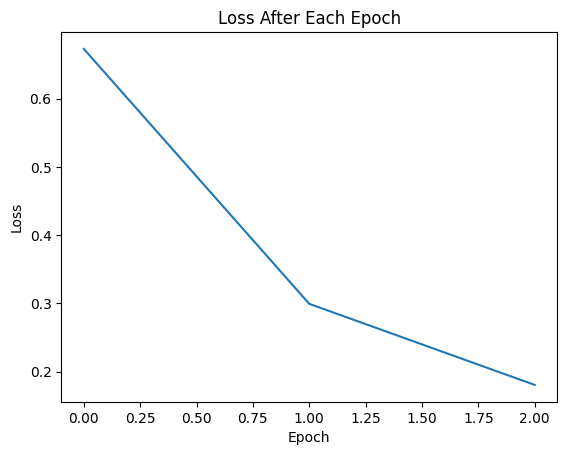

{'eval_loss': 0.292750746011734, 'eval_accuracy': 0.9025, 'eval_runtime': 36.3688, 'eval_samples_per_second': 54.992, 'eval_steps_per_second': 3.437, 'epoch': 3.0}


In [ ]:
from transformers import TrainerCallback, Trainer, TrainingArguments, EvalPrediction
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

class LossPlotCallback(TrainerCallback):
    "A callback that records the loss after each epoch"
    def __init__(self):
        self.losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Record the loss at the end of each epoch
        self.losses.append(state.log_history[-1]['loss'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3
)


# Initialize the callback
loss_plot_callback = LossPlotCallback()

# Initialize Trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[loss_plot_callback]
)

# Train the model
trainer.train()

# Plot the loss
plt.plot(loss_plot_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss After Each Epoch')
plt.show()

validation_results = trainer.evaluate()
print(validation_results)

## Changing Number of Hidden Layers

In [3]:
from transformers import DistilBertModel, DistilBertConfig
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
config = DistilBertConfig.from_pretrained(model_name)
model = DistilBertModel(config)

(…)uncased-emotion/resolve/main/config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

In [4]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load tokenizer and dataset
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
dataset = load_dataset("dair-ai/emotion")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Customize the model configuration
config = DistilBertConfig.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion', n_layers=8)


# Initialize the model with custom configuration
model = DistilBertForSequenceClassification(config)

(…)otion/resolve/main/tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

(…)e-uncased-emotion/resolve/main/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)ion/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss
500,1.458900
1000,0.776100
1500,0.369200
2000,0.301900
2500,0.207700
3000,0.181300


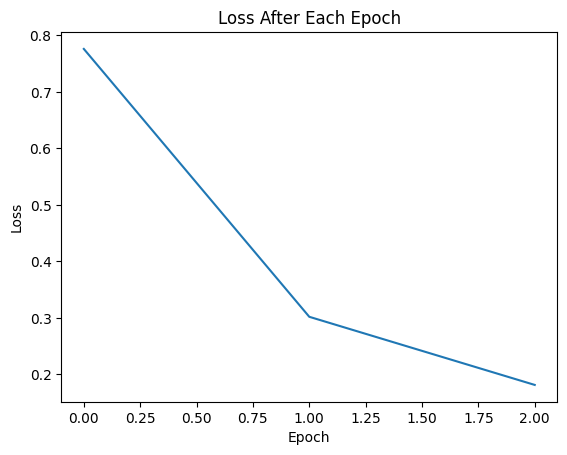

{'eval_loss': 0.27587974071502686, 'eval_accuracy': 0.8975, 'eval_runtime': 47.6185, 'eval_samples_per_second': 42.0, 'eval_steps_per_second': 2.625, 'epoch': 3.0}


In [5]:
from transformers import TrainerCallback, Trainer, TrainingArguments, EvalPrediction
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

class LossPlotCallback(TrainerCallback):
    "A callback that records the loss after each epoch"
    def __init__(self):
        self.losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Record the loss at the end of each epoch
        self.losses.append(state.log_history[-1]['loss'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3
)


# Initialize the callback
loss_plot_callback = LossPlotCallback()

# Initialize Trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[loss_plot_callback]
)

# Train the model
trainer.train()

# Plot the loss
plt.plot(loss_plot_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss After Each Epoch')
plt.show()

validation_results = trainer.evaluate()
print(validation_results)

## Change Number of Heads

In [10]:
from transformers import DistilBertModel, DistilBertConfig
model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
config = DistilBertConfig.from_pretrained(model_name)
model = DistilBertModel(config)

In [8]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset

# Load tokenizer and dataset
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
dataset = load_dataset("dair-ai/emotion")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Customize the model configuration
config = DistilBertConfig.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion', n_heads=16)


# Initialize the model with custom configuration
model = DistilBertForSequenceClassification(config)

Step,Training Loss
500,1.424200
1000,0.739700
1500,0.421500
2000,0.326100
2500,0.228900
3000,0.198700


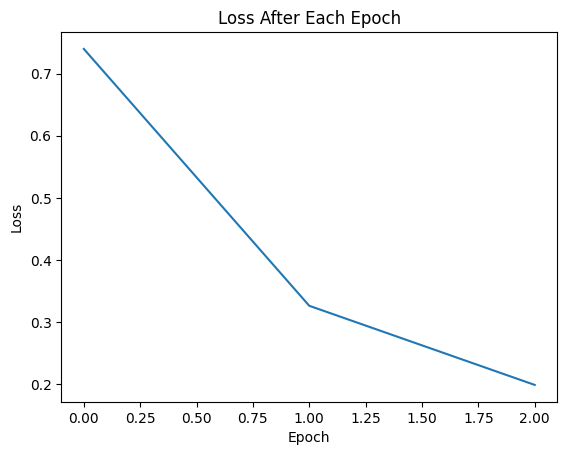

{'eval_loss': 0.2980455458164215, 'eval_accuracy': 0.8965, 'eval_runtime': 37.5614, 'eval_samples_per_second': 53.246, 'eval_steps_per_second': 3.328, 'epoch': 3.0}


In [9]:
from transformers import TrainerCallback, Trainer, TrainingArguments, EvalPrediction
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

class LossPlotCallback(TrainerCallback):
    "A callback that records the loss after each epoch"
    def __init__(self):
        self.losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Record the loss at the end of each epoch
        self.losses.append(state.log_history[-1]['loss'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3
)


# Initialize the callback
loss_plot_callback = LossPlotCallback()

# Initialize Trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[loss_plot_callback]
)

# Train the model
trainer.train()

# Plot the loss
plt.plot(loss_plot_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss After Each Epoch')
plt.show()

validation_results = trainer.evaluate()
print(validation_results)

## Comparison Experiments

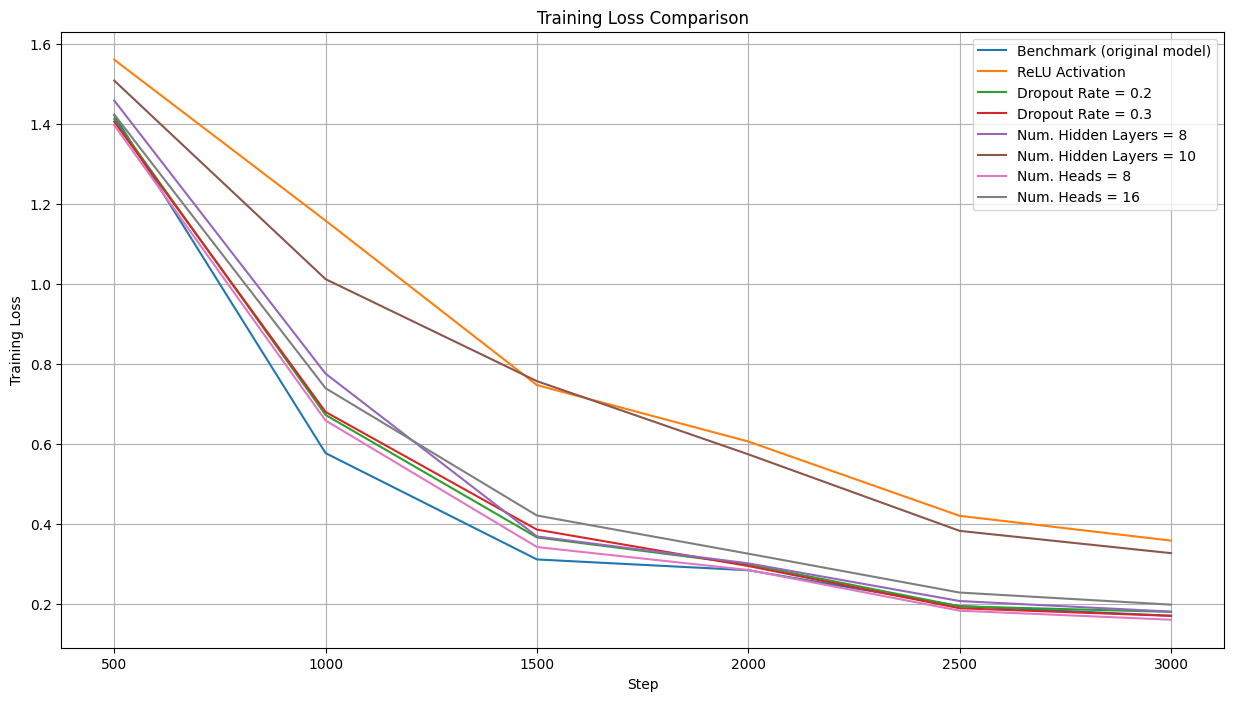

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
df1 = pd.read_csv('/content/benchmark_bert.csv') # Replace path_to_file_1.csv with actual file name
df2 = pd.read_csv('/content/relu_bert.csv')
df3 = pd.read_csv('/content/dropout_0.2_bert.csv')
df4 = pd.read_csv('/content/dropout_0.3_bert.csv')
df5 = pd.read_csv('/content/layers_8_bert.csv')
df6 = pd.read_csv('/content/layers_10_bert.csv')
df7 = pd.read_csv('/content/heads_8_bert.csv')
df8 = pd.read_csv('/content/heads_16.csv')

# Plotting
plt.figure(figsize=(15, 8))  # Increased figure size

plt.plot(df1['Step'], df1['Training Loss'], label='Benchmark (original model)')
plt.plot(df2['Step'], df2['Training Loss'], label='ReLU Activation')
plt.plot(df3['Step'], df3['Training Loss'], label='Dropout Rate = 0.2')
plt.plot(df4['Step'], df4['Training Loss'], label='Dropout Rate = 0.3')
plt.plot(df5['Step'], df5['Training Loss'], label='Num. Hidden Layers = 8')
plt.plot(df6['Step'], df6['Training Loss'], label='Num. Hidden Layers = 10')
plt.plot(df7['Step'], df7['Training Loss'], label='Num. Heads = 8')
plt.plot(df8['Step'], df8['Training Loss'], label='Num. Heads = 16')

# Customizing the plot
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
config

DistilBertConfig {
  "_name_or_path": "./",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.2",
  "vocab_size": 30522
}